# (CT-236) Lab 3: Simulando Redes Girvan-Newman
---

In [1]:
from igraph import *
from PIL import Image
from matplotlib import pyplot as plt
from math import log, floor, exp
import matplotlib.image as mpimg
import networkx as nx
import numpy as np
import pandas as pd
import random
import timeit

In [2]:
def decision(probability):
    return random.random() < probability

def plot_graph(g, layout_name, filename):
    visual_style = {}
#     visual_style["vertex_size"] = 2
#     visual_style["edge_width"] = 1
#     visual_style["bbox"] = (300, 300)
#     visual_style["margin"] = 20
    visual_style["layout"] = g.layout(layout_name)
    plot(g, "plots/" + filename, **visual_style)
    return Image.open("plots/" + filename)

def girvan_newman(community_sizes, zin, zout, debug=False, debug_colors=[]):
    # Total de nós
    total_nodes = 0
    for size in community_sizes:
        total_nodes += size
    
    # Inicia um grafo com n_communities * n_per_community nós
    g = Graph()
    g.add_vertices(total_nodes)
    
    # Mapeia os nós em comunidades
    communities = []
    aux = 0
    for size in community_sizes:
        community_members = []
        for i in range(size):
            community_members.append(aux)
            aux += 1
        communities.append(community_members)
            
    # Zin e Zout (contadores para meta de zin e zou de cada elemento)
    Zin = []
    Zout = []
    for i in range(total_nodes):
        Zin.append(zin)
        Zout.append(zout)
    
    for community in communities:
        # Lista de conexões
        connections = {}
        for member in community:
            connections[member] = set()

        # Edge list
        edge_list = []

        # Monta as conexões (internas)
        global_available_nodes = community.copy()
        while len(global_available_nodes) > 0:
            for member in global_available_nodes:
                available_nodes = global_available_nodes.copy()
                available_nodes.remove(member)
                for connection in connections[member]:
                    if connection in available_nodes:
                        available_nodes.remove(connection)
                while Zin[member] > 0:
                    if len(available_nodes) == 0:
                        break
                    other_member = random.choice(available_nodes)
                    Zin[member] -= 1
                    Zin[other_member] -= 1
                    connections[member].add(other_member)
                    connections[other_member].add(member)
                    edge_list.append((member, other_member))
                    available_nodes.remove(other_member)
                    if Zin[other_member] == 0:
                        global_available_nodes.remove(other_member)
                global_available_nodes.remove(member)
    
        # Efetiva as conexões
        g.add_edges(edge_list)
    
    # Monta as conexões (externas)
    global_available_nodes = []
    connections = {}
    for community in communities:
        for member in community:
            connections[member] = set()
            global_available_nodes.append(member)

    # Edge list
    edge_list = []
    
    while len(global_available_nodes) > 0:
        for member in global_available_nodes:
            available_nodes = global_available_nodes.copy()
            my_community = []
            for community in communities:
                if member in community:
                    my_community = community
            for brother in my_community:
                if brother in available_nodes:
                    available_nodes.remove(brother)
            for connection in connections[member]:
                if connection in available_nodes:
                    available_nodes.remove(connection)
            while Zout[member] > 0:
                if len(available_nodes) == 0:
                    break
                other_member = random.choice(available_nodes)
                Zout[member] -= 1
                Zout[other_member] -= 1
                connections[member].add(other_member)
                connections[other_member].add(member)
                edge_list.append((member, other_member))
                available_nodes.remove(other_member)
                if Zout[other_member] == 0:
                    global_available_nodes.remove(other_member)
            global_available_nodes.remove(member)
        
    # Efetiva as conexões
    g.add_edges(edge_list)
            
    # Debug (colorir quatro comunidades)
    if debug:
        aux = 0
        for color in debug_colors:
            for member in communities[aux]:
                g.vs[member]["color"] = color
            aux += 1
            
    return g

## Testando a função criada (inspeção visual)
### 4 Comunidades de tamanhos simétricos

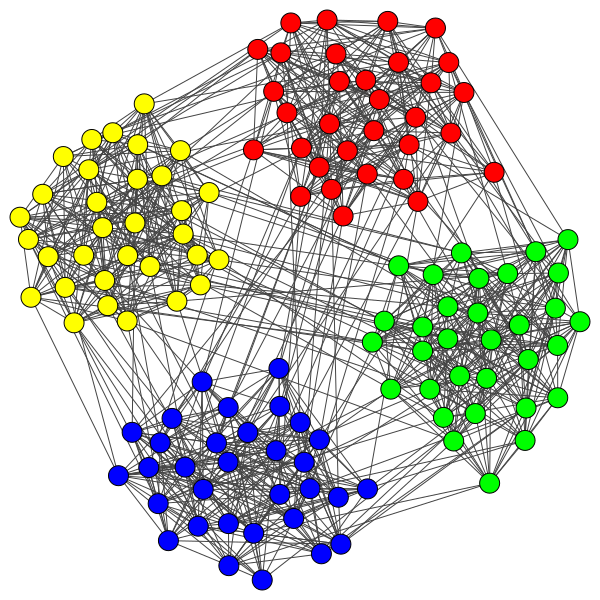

In [3]:
g = girvan_newman([32, 32, 32, 32],14,2, debug=True, debug_colors=["green", "red", "yellow", "blue"])
plot_graph(g, "auto", "visual.png")

### 2 Comunidades de tamanhos assimétricos

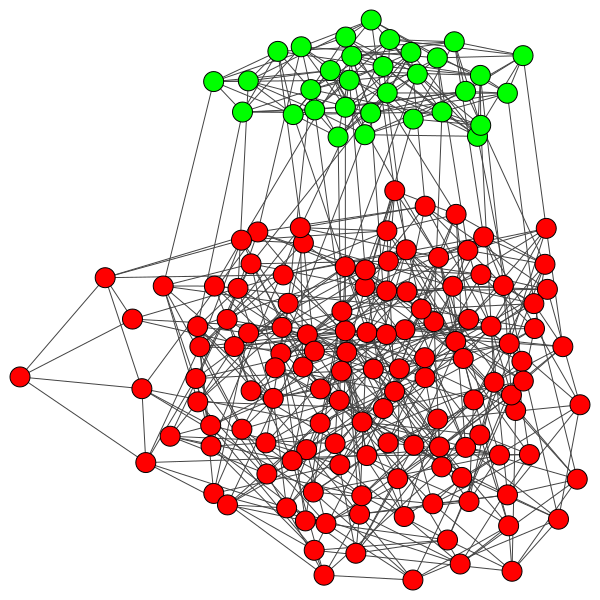

In [4]:
g = girvan_newman([32, 128],7,1, debug=True, debug_colors=["green", "red"])
plot_graph(g, "auto", "visual2.png")

---
## Análise Espectral

### Parâmetros editáveis

In [5]:
# ==== Parâmetros ====
num_simulations = 5

# Z = z_in + z_out
Z = 16

### Particionamento espectral

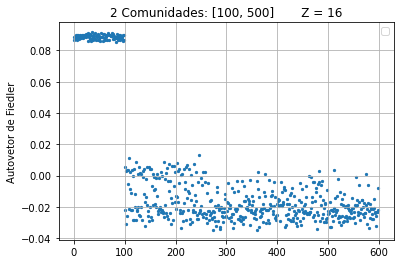

In [6]:
size = [100, 500]

eig_values = []
fiedler_values = []
fiedler_vectors = []
subtitles = []
ratio = []

g = girvan_newman(size, 10, 2, debug=True, debug_colors=['red', 'green'])

# Calcular os autovalores/autovetores
L = g.laplacian()

# Propriedades espectrais
a = np.array(L)
w, v = np.linalg.eig(a)
idx = w.argsort()[::]   
w = w[idx]
v = v[:,idx]

# Fiedler
fiedler_value = w[1]
fiedler_vector = v[:,1]

idx = [*range(len(fiedler_vector))]
plt.scatter(idx, fiedler_vector, s=5)

plt.ylabel("Autovetor de Fiedler")

# Style
plt.rcParams["font.family"] = "serif"
plt.grid(True)
plt.legend(subtitles)
plt.title(str(len(size)) + " Comunidades: " + str(size) + "       Z = " + str(Z))

plt.savefig('plots/part-espec-1', dpi=400)
plt.show()

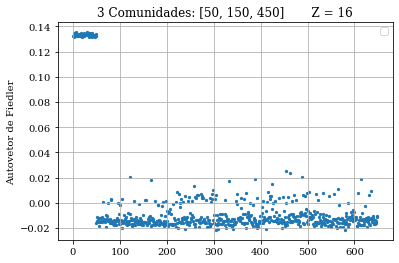

In [7]:
size = [50, 150, 450]

eig_values = []
fiedler_values = []
fiedler_vectors = []
subtitles = []
ratio = []

g = girvan_newman(size, 10, 2, debug=True, debug_colors=['red', 'green'])

# Calcular os autovalores/autovetores
L = g.laplacian()

# Propriedades espectrais
a = np.array(L)
w, v = np.linalg.eig(a)
idx = w.argsort()[::]   
w = w[idx]
v = v[:,idx]

# Fiedler
fiedler_value = w[1]
fiedler_vector = v[:,1]

idx = [*range(len(fiedler_vector))]
plt.scatter(idx, fiedler_vector, s=5)

plt.ylabel("Autovetor de Fiedler")

# Style
plt.rcParams["font.family"] = "serif"
plt.grid(True)
plt.legend(subtitles)
plt.title(str(len(size)) + " Comunidades: " + str(size) + "       Z = " + str(Z))

plt.savefig('plots/part-espec-2', dpi=400)
plt.show()

### Rede simétrica (2 comunidades)

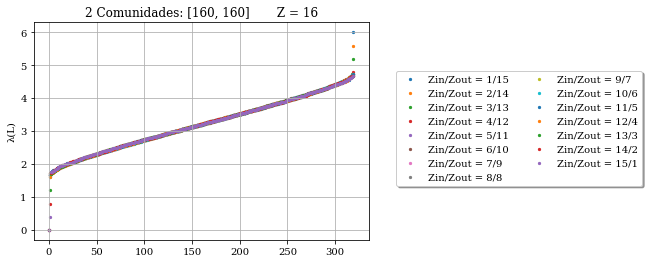

In [8]:
size = [160, 160]

eig_values = []
fiedler_values = []
subtitles = []
ratio = []

z_in = 1
z_out = Z - z_in

while z_in < Z:
    for i in range(num_simulations):
        avg_w = 0
        avg_fid = 0
        g = girvan_newman(size, z_in, z_out)

        # Calcular os autovalores/autovetores
        L = g.laplacian()

        # Propriedades espectrais
        a = np.array(L)
        w, v = np.linalg.eig(a)
        w.sort()
        avg_w += w
        avg_fid += w[1]
        
    # Calcula a média das simulações
    avg_w = avg_w / num_simulations
    avg_fid = avg_fid / num_simulations
    eig_values.append(avg_w)
    fiedler_values.append(avg_fid)
    ratio.append(r'$\frac{'+ str(z_in) + '}{' + str(z_out) + '}$')

    # Legenda
    subtitles.append('Zin/Zout = ' + str(z_in) + '/' + str(z_out))

    z_in += 1
    z_out -= 1
    
for value in eig_values:
    idx = [*range(len(value))]
    plt.scatter(idx, value, s=5)

#plt.title("Coeficiente de agrupamento (CC) em função de n^(-3/4)")
plt.ylabel("λ(L)")

# Style
plt.rcParams["font.family"] = "serif"
plt.grid(True)
plt.legend(subtitles, loc='upper center', bbox_to_anchor=(1.45, 0.8), shadow=True, ncol=2)
plt.title(str(len(size)) + " Comunidades: " + str(size) + "       Z = " + str(Z))

plt.savefig('plots/ratio-2c-sim.png', dpi=400, bbox_inches="tight")
plt.show()

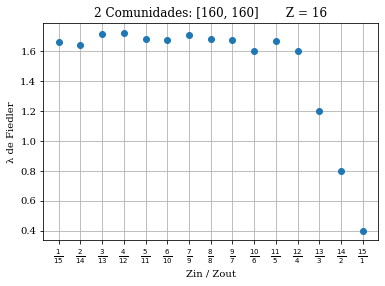

In [9]:
plt.plot(ratio, fiedler_values, 'o')

plt.xlabel("Zin / Zout")
plt.ylabel("λ de Fiedler")

# Style
plt.rcParams["font.family"] = "serif"
plt.grid(True)
plt.title(str(len(size)) + " Comunidades: " + str(size) + "       Z = " + str(Z))

plt.savefig('plots/fiedler-2c-sim.png', dpi=400, bbox_inches="tight")
plt.show()

### Rede simétrica (5 comunidades)

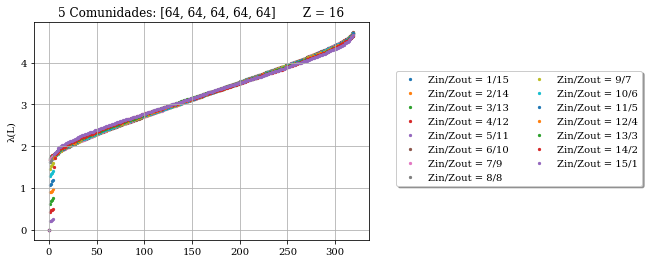

In [10]:
size = [64, 64, 64, 64, 64]

eig_values = []
fiedler_values = []
subtitles = []

z_in = 1
z_out = Z - z_in

while z_in < Z:
    for i in range(num_simulations):
        avg_w = 0
        avg_fid = 0
        g = girvan_newman(size, z_in, z_out)

        # Calcular os autovalores/autovetores
        L = g.laplacian()

        # Propriedades espectrais
        a = np.array(L)
        w, v = np.linalg.eig(a)
        w.sort()
        avg_w += w
        avg_fid += w[1]
        
    # Calcula a média das simulações
    avg_w = avg_w / num_simulations
    avg_fid = avg_fid / num_simulations
    eig_values.append(avg_w)
    fiedler_values.append(avg_fid)

    # Legenda
    subtitles.append('Zin/Zout = ' + str(z_in) + '/' + str(z_out))

    z_in += 1
    z_out -= 1
    
for value in eig_values:
    idx = [*range(len(value))]
    plt.scatter(idx, value, s=5)

#plt.title("Coeficiente de agrupamento (CC) em função de n^(-3/4)")
plt.ylabel("λ(L)")

# Style
plt.rcParams["font.family"] = "serif"
plt.grid(True)
plt.legend(subtitles, loc='upper center', bbox_to_anchor=(1.45, 0.8), shadow=True, ncol=2)
plt.title(str(len(size)) + " Comunidades: " + str(size) + "       Z = " + str(Z))

plt.savefig('plots/ratio-5c-sim.png', dpi=400, bbox_inches="tight")
plt.show()

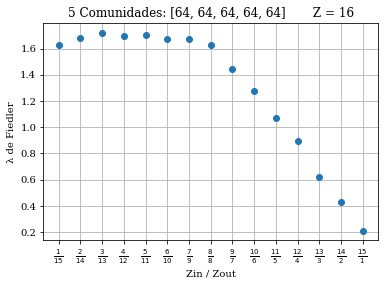

In [11]:
plt.plot(ratio, fiedler_values, 'o')

plt.xlabel("Zin / Zout")
plt.ylabel("λ de Fiedler")

# Style
plt.rcParams["font.family"] = "serif"
plt.grid(True)
plt.title(str(len(size)) + " Comunidades: " + str(size) + "       Z = " + str(Z))

plt.savefig('plots/fiedler-5c-sim.png', dpi=400, bbox_inches="tight")
plt.show()

### Rede assimétrica (2 comunidades)

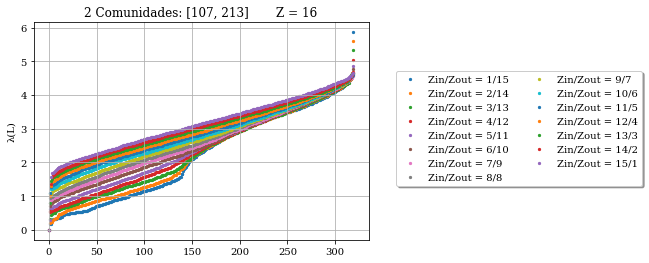

In [12]:
size = [107, 213]

eig_values = []
fiedler_values = []
subtitles = []

z_in = 1
z_out = Z - z_in

while z_in < Z:
    for i in range(num_simulations):
        avg_w = 0
        avg_fid = 0
        g = girvan_newman(size, z_in, z_out)

        # Calcular os autovalores/autovetores
        L = g.laplacian()

        # Propriedades espectrais
        a = np.array(L)
        w, v = np.linalg.eig(a)
        w.sort()
        avg_w += w
        avg_fid += w[1]
        
    # Calcula a média das simulações
    avg_w = avg_w / num_simulations
    avg_fid = avg_fid / num_simulations
    eig_values.append(avg_w)
    fiedler_values.append(avg_fid)

    # Legenda
    subtitles.append('Zin/Zout = ' + str(z_in) + '/' + str(z_out))

    z_in += 1
    z_out -= 1
    
for value in eig_values:
    idx = [*range(len(value))]
    plt.scatter(idx, value, s=5)

#plt.title("Coeficiente de agrupamento (CC) em função de n^(-3/4)")
plt.ylabel("λ(L)")

# Style
plt.rcParams["font.family"] = "serif"
plt.grid(True)
plt.legend(subtitles, loc='upper center', bbox_to_anchor=(1.45, 0.8), shadow=True, ncol=2)
plt.title(str(len(size)) + " Comunidades: " + str(size) + "       Z = " + str(Z))

plt.savefig('plots/ratio-2c-assim.png', dpi=400, bbox_inches="tight")
plt.show()

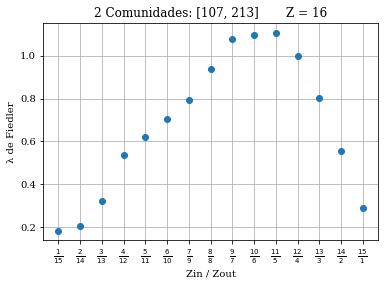

In [13]:
plt.plot(ratio, fiedler_values, 'o')

plt.xlabel("Zin / Zout")
plt.ylabel("λ de Fiedler")

# Style
plt.rcParams["font.family"] = "serif"
plt.grid(True)
plt.title(str(len(size)) + " Comunidades: " + str(size) + "       Z = " + str(Z))

plt.savefig('plots/fiedler-2c-assim.png', dpi=400, bbox_inches="tight")
plt.show()

### Rede assimétrica (5 comunidades)

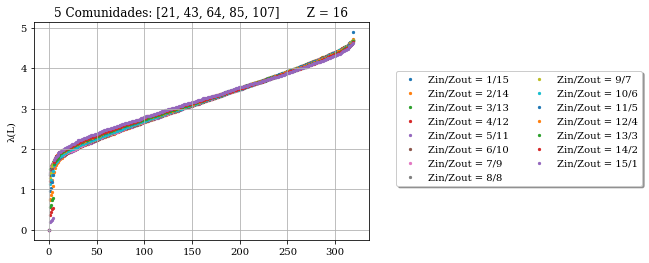

In [14]:
size = [21, 43, 64, 85, 107]

eig_values = []
fiedler_values = []
subtitles = []

z_in = 1
z_out = Z - z_in

while z_in < Z:
    for i in range(num_simulations):
        avg_w = 0
        avg_fid = 0
        g = girvan_newman(size, z_in, z_out)

        # Calcular os autovalores/autovetores
        L = g.laplacian()

        # Propriedades espectrais
        a = np.array(L)
        w, v = np.linalg.eig(a)
        w.sort()
        avg_w += w
        avg_fid += w[1]
        
    # Calcula a média das simulações
    avg_w = avg_w / num_simulations
    avg_fid = avg_fid / num_simulations
    eig_values.append(avg_w)
    fiedler_values.append(avg_fid)

    # Legenda
    subtitles.append('Zin/Zout = ' + str(z_in) + '/' + str(z_out))

    z_in += 1
    z_out -= 1
    
for value in eig_values:
    idx = [*range(len(value))]
    plt.scatter(idx, value, s=5)

#plt.title("Coeficiente de agrupamento (CC) em função de n^(-3/4)")
plt.ylabel("λ(L)")

# Style
plt.rcParams["font.family"] = "serif"
plt.grid(True)
plt.legend(subtitles, loc='upper center', bbox_to_anchor=(1.45, 0.8), shadow=True, ncol=2)
plt.title(str(len(size)) + " Comunidades: " + str(size) + "       Z = " + str(Z))

plt.savefig('plots/ratio-5c-assim.png', dpi=400, bbox_inches="tight")
plt.show()

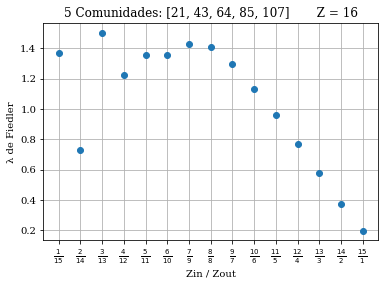

In [15]:
plt.plot(ratio, fiedler_values, 'o')

plt.xlabel("Zin / Zout")
plt.ylabel("λ de Fiedler")

# Style
plt.rcParams["font.family"] = "serif"
plt.grid(True)
plt.title(str(len(size)) + " Comunidades: " + str(size) + "       Z = " + str(Z))

plt.savefig('plots/fiedler-5c-assim.png', dpi=400, bbox_inches="tight")
plt.show()

### Apenas uma comunidade assimétrica

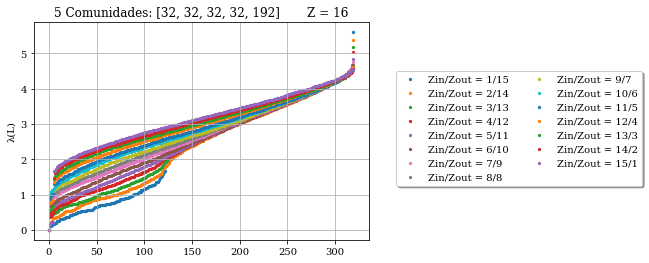

In [16]:
size = [32, 32, 32, 32, 192]

eig_values = []
fiedler_values = []
subtitles = []

z_in = 1
z_out = Z - z_in

while z_in < Z:
    for i in range(num_simulations):
        avg_w = 0
        avg_fid = 0
        g = girvan_newman(size, z_in, z_out)

        # Calcular os autovalores/autovetores
        L = g.laplacian()

        # Propriedades espectrais
        a = np.array(L)
        w, v = np.linalg.eig(a)
        w.sort()
        avg_w += w
        avg_fid += w[1]
        
    # Calcula a média das simulações
    avg_w = avg_w / num_simulations
    avg_fid = avg_fid / num_simulations
    eig_values.append(avg_w)
    fiedler_values.append(avg_fid)

    # Legenda
    subtitles.append('Zin/Zout = ' + str(z_in) + '/' + str(z_out))

    z_in += 1
    z_out -= 1
    
for value in eig_values:
    idx = [*range(len(value))]
    plt.scatter(idx, value, s=5)

#plt.title("Coeficiente de agrupamento (CC) em função de n^(-3/4)")
plt.ylabel("λ(L)")

# Style
plt.rcParams["font.family"] = "serif"
plt.grid(True)
plt.legend(subtitles, loc='upper center', bbox_to_anchor=(1.45, 0.8), shadow=True, ncol=2)
plt.title(str(len(size)) + " Comunidades: " + str(size) + "       Z = " + str(Z))

plt.savefig('plots/ratio-5c-assim1.png', dpi=400, bbox_inches="tight")
plt.show()

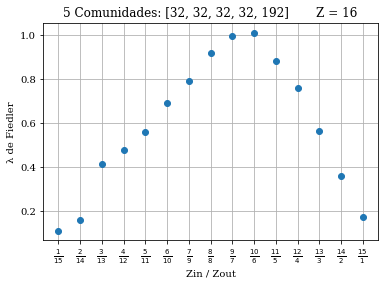

In [17]:
plt.plot(ratio, fiedler_values, 'o')

plt.xlabel("Zin / Zout")
plt.ylabel("λ de Fiedler")

# Style
plt.rcParams["font.family"] = "serif"
plt.grid(True)
plt.title(str(len(size)) + " Comunidades: " + str(size) + "       Z = " + str(Z))

plt.savefig('plots/fiedler-5c-assim1.png', dpi=400, bbox_inches="tight")
plt.show()

---
## Número de comunidades
### Parâmetros editáveis

In [18]:
# ==== Parâmetros ====
num_simulations = 5

# z_in e z_out
z_in = 14
z_out = 2
Z = z_in + z_out

# Comunidades
communities_sizes = []
communities_sizes.append([160, 160])
communities_sizes.append([64, 64, 64, 64, 64])
communities_sizes.append([40, 40, 40, 40, 40, 40, 40, 40])

### Análise

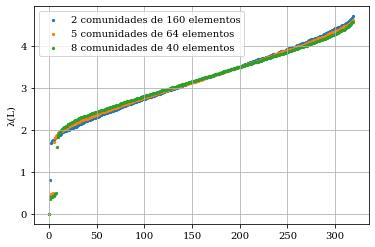

In [19]:
subtitles = []

for size in communities_sizes:
    for i in range(num_simulations):
        avg_w = 0
        avg_fid = 0
        g = girvan_newman(size, z_in, z_out)

        # Calcular os autovalores/autovetores
        L = g.laplacian()

        # Propriedades espectrais
        a = np.array(L)
        w, v = np.linalg.eig(a)
        w.sort()
        avg_w += w
        avg_fid += w[1]
        
    # Calcula a média das simulações
    avg_w = avg_w / num_simulations
    avg_fid = avg_fid / num_simulations

    idx = [*range(len(avg_w))]
    subtitles.append(str(len(size)) + ' comunidades de ' + str(size[0]) + ' elementos')
    plt.scatter(idx, avg_w, s=5)

#plt.title("Coeficiente de agrupamento (CC) em função de n^(-3/4)")
plt.ylabel("λ(L)")

# Style
plt.rcParams["font.family"] = "serif"
plt.grid(True)
plt.legend(subtitles)
plt.title('')

plt.savefig('plots/com-size.png', dpi=400)
plt.show()

---
## Proporção entre comunidades
### Parâmetros editáveis

In [20]:
# ==== Parâmetros ====
num_simulations = 5

# z_in e z_out
z_in = 14
z_out = 2
Z = z_in + z_out

# Comunidades
communities_sizes = []
communities_sizes.append([160, 160])
communities_sizes.append([107, 213])
communities_sizes.append([80, 240])
communities_sizes.append([64, 256])

### Análise

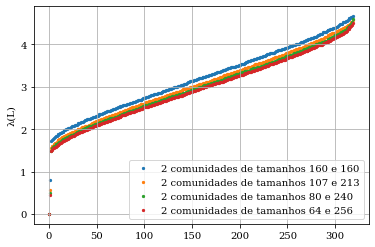

In [21]:
subtitles = []

for size in communities_sizes:
    for i in range(num_simulations):
        avg_w = 0
        avg_fid = 0
        g = girvan_newman(size, z_in, z_out)

        # Calcular os autovalores/autovetores
        L = g.laplacian()

        # Propriedades espectrais
        a = np.array(L)
        w, v = np.linalg.eig(a)
        w.sort()
        avg_w += w
        avg_fid += w[1]
        
    # Calcula a média das simulações
    avg_w = avg_w / num_simulations
    avg_fid = avg_fid / num_simulations

    idx = [*range(len(avg_w))]
    subtitles.append('2 comunidades de tamanhos ' + str(size[0]) + ' e ' + str(size[1]))
    plt.scatter(idx, avg_w, s=5)

#plt.title("Coeficiente de agrupamento (CC) em função de n^(-3/4)")
plt.ylabel("λ(L)")

# Style
plt.rcParams["font.family"] = "serif"
plt.grid(True)
plt.legend(subtitles)
plt.title('')

plt.savefig('plots/com-prop.png', dpi=400)
plt.show()

---
## Comparação com Erdös-Rényi
### Parâmetros editáveis

In [22]:
# ==== Parâmetros ====
num_simulations = 5

# z_in e z_out
z_in = 14
z_out = 2
Z = z_in + z_out

# Comunidades
test = [128, 128, 128, 128]
n = 512
q = Z/n

### Comparação

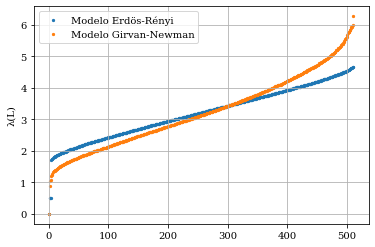

In [23]:
subtitles = []

for i in range(num_simulations):
    avg_w_gn = 0
    avg_fid_gn = 0
    avg_w_er = 0
    avg_fid_er = 0
    gn = girvan_newman(test, z_in, z_out)
    er = Graph.Erdos_Renyi(n, q, directed=False)

    # Calcular os autovalores/autovetores
    L_gn = gn.laplacian()
    L_er = er.laplacian()

    # Propriedades espectrais
    a = np.array(L_gn)
    w, v = np.linalg.eig(a)
    w.sort()
    avg_w_gn += w
    avg_fid_gn += w[1]

    a = np.array(L_er)
    w, v = np.linalg.eig(a)
    w.sort()
    avg_w_er += w
    avg_fid_er += w[1]

# Calcula a média das simulações
avg_w_gn = avg_w_gn / num_simulations
avg_fid_gn = avg_fid_gn / num_simulations
avg_w_er = avg_w_er / num_simulations
avg_fid_er = avg_fid_er / num_simulations

idx = [*range(len(avg_w_gn))]
subtitles.append('Modelo Erdös-Rényi')
plt.scatter(idx, avg_w_gn, s=5)
idx = [*range(len(avg_w_er))]
subtitles.append('Modelo Girvan-Newman')
plt.scatter(idx, avg_w_er, s=5)

plt.ylabel("λ(L)")

# Style
plt.rcParams["font.family"] = "serif"
plt.grid(True)
plt.legend(subtitles)
plt.title('')

plt.savefig('plots/comparacao-er.png', dpi=400)
plt.show()

In [24]:
print('Fiedler ER: ' + str(avg_fid_er))
print('Fiedler GN: ' + str(avg_fid_gn))

Fiedler ER: 0.9010627915888542
Fiedler GN: 0.4966950977082306


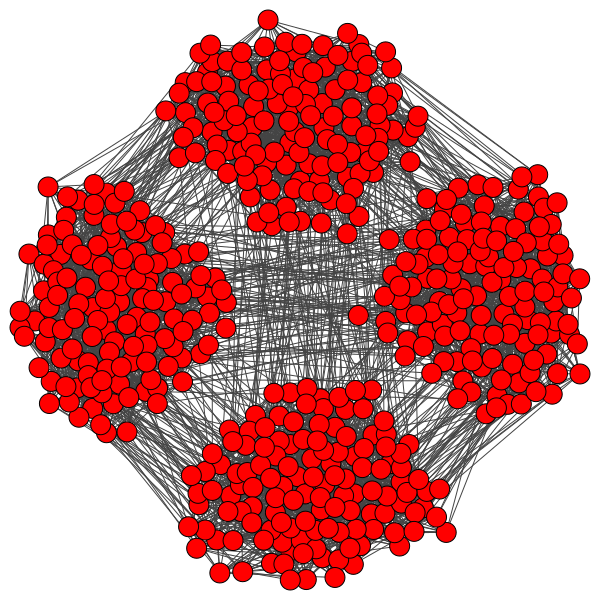

In [25]:
plot_graph(gn, "auto", "teste-gn.png")

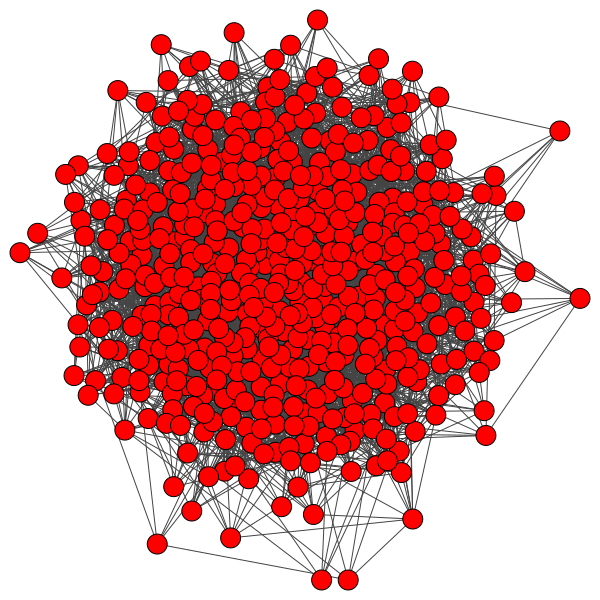

In [26]:
plot_graph(er, "auto", "teste-er.png")

---
## Detecção de Comunidades
### Importando redes reais (facebook-combined & lastfm_asia)

In [27]:
# ==== Importar arquivo do Facebook ====
file_fb = np.loadtxt('facebook_combined.txt')

# Pegar o número total de nós e montar as conexões
total_nodes = 0
edge_list = []
for row in file_fb:
    if row[0] > total_nodes:
        total_nodes = row[0]
    if row[1] > total_nodes:
        total_nodes = row[1]
    edge_list.append( (floor(row[0]), floor(row[1])) )
total_nodes = floor(total_nodes) + 1
        
# Montar a rede no igraph
g_fb = Graph()
g_fb.add_vertices(total_nodes)
g_fb.add_edges(edge_list)


# ==== Importar arquivo do LastFM ====
file_fm = pd.read_csv('lastfm_asia_edges.csv', sep = ",")

# Pegar o número total de nós e montar as conexões
total_nodes = 0
edge_list = []
for index, row in file_fm.iterrows():
    if row['node_1'] > total_nodes:
        total_nodes = row['node_1']
    if row['node_2'] > total_nodes:
        total_nodes = row['node_2']
    edge_list.append((row['node_1'], row['node_2']))
total_nodes = floor(total_nodes) + 1

# Montar a rede no igraph
g_fm = Graph()
g_fm.add_vertices(total_nodes)
g_fm.add_edges(edge_list)

### Por Fast-Greedy

In [28]:
start_time = timeit.default_timer()

clustering = g_fb.community_fastgreedy().as_clustering()
print('Modularity: ', g_fb.modularity(clustering))

print('Exec Time = ', timeit.default_timer() - start_time)

Modularity:  0.7773806408102405
Exec Time =  0.39137087099970813


In [29]:
start_time = timeit.default_timer()


clustering = g_fm.community_fastgreedy().as_clustering()
print('Modularity: ', g_fm.modularity(clustering))

print('Exec Time = ', timeit.default_timer() - start_time)

Modularity:  0.7965711391638808
Exec Time =  0.48104939099994226


### Por Multilevel

In [30]:
start_time = timeit.default_timer()

clustering = g_fb.community_multilevel(return_levels=False)
print('Modularity: ', g_fb.modularity(clustering))

print('Exec Time = ', timeit.default_timer() - start_time)

Modularity:  0.8347862911065229
Exec Time =  0.12404781199984427


In [31]:
start_time = timeit.default_timer()

clustering = g_fm.community_multilevel(return_levels=False)
print('Modularity: ', g_fm.modularity(clustering))

print('Exec Time = ', timeit.default_timer() - start_time)

Modularity:  0.8137779163747891
Exec Time =  0.07979366000017762


### Por Edge-Betweenness

In [ ]:
start_time = timeit.default_timer()

clustering = g_fb.community_edge_betweenness(directed=False)
print('Modularity: ', g_fb.modularity(clustering))

print('Exec Time = ', timeit.default_timer() - start_time)

In [ ]:
start_time = timeit.default_timer()

clustering = g_fm.community_edge_betweenness(directed=False)
print('Modularity: ', g_fm.modularity(clustering))

print('Exec Time = ', timeit.default_timer() - start_time)